In [23]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from time import time
from os import path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM

In [2]:
def lorenz(t, y, params):
    """
    Diferencialne enacbe Lorentzovega modela
    y = [x,y,z]
    dy = [dx/dt, dy/dt, dz/dt]
    params=[sigma,rho,beta]
    """
    dy=np.zeros(3)
    dy[0]=params[0]*(y[1]-y[0])
    dy[1]=(params[1]-y[2])*y[0] - y[1]
    dy[2]=y[0]*y[1] - params[2]*y[2]
    return dy

### Integracija Lorenzovega sistema v času ###

# definiarmo vrenosti parametrov params=[sigma,rho,beta]
params = [10., 28.,8./3.]

#nastavimo zacetni cas na 0
t = 0.
#dolzina casovnega koraka
dt=0.01

#koncni cas integracije
tmax=10000.

#Dolocimo vrednosti spremenljivk x,y, ob casu 0;
#nakljucne vrednosti so zrebane po enakomerni porazdelitvi
y0_ATM = np.array([np.random.uniform(-20,20),np.random.uniform(-20,20),np.random.uniform(10,30)])

# nasa njboljsa ocena trenutnega stanja ozracja ima napako
c=0.2
y0_MOD=y0_ATM + c*np.random.random(3)

#nastavimo integrator
solver_ATM=ode(lorenz).set_integrator('dopri5')
solver_ATM.set_f_params(params)
solver_ATM.set_initial_value(y0_ATM, t)

solver_MOD=ode(lorenz).set_integrator('dopri5')
solver_MOD.set_f_params(params)
solver_MOD.set_initial_value(y0_ATM, t)

In [3]:
if(path.exists("data/data-2.npy") != 1):
    print("Generating data.")
    n = int(tmax/dt) + 1
    data = np.zeros((n, 3))

    i = 0
    start = time()
    while t < tmax:
        y_ATM = solver_ATM.integrate(t+dt)
        #y0_MOD = solver_MOD.integrate(t+dt)
        data[i, :] = y_ATM[:]
        i = i + 1
        t += dt
    print("Elasped time: %0.3g s" %(time()-start))
    data = data[1000:] # only use data from the attractor (after time = 10000 * dt)
    print("Integration finished.")
    np.save("data/data-2.npy", data)
    
else:
    print("Data exist.")
    data = np.load("data/data-2.npy")
    print("Data loaded.")

Data exist.
Data loaded.


In [7]:
#PREPROCESS DATA
#additional preprocess data
from sklearn.preprocessing import MinMaxScaler
Nend = 10000
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data)
normalized_data = scaler.transform(data)

time_steps_predictor = 10

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        # if beyond datasete, break
        if end_ix > len(sequences)-1:
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, Y = split_sequences(normalized_data, time_steps_predictor)

#new_order=np.random.choice(range(x_train.shape[0]),x_train.shape[0],replace=False)
#x_train_norm=x_train_norm[new_order]
#y_train_norm=y_train_norm[new_order]

In [42]:
# RNN
#Ustvarimo funkcijo, ki vrača kompajlan RNN model
def create_model_RNN(activation='tanh', optimizer='adam', n_steps=1):
    
    model = tf.keras.models.Sequential()
    model.add(SimpleRNN(16, activation=activation, input_shape=(n_steps, 3)))
    model.add(Dense(3))
    #model.add(Dropout(0.2))
    #model.add(Dense(81, activation=activation))
    #model.add(Dropout(0.2))
    #model.add(Dense(81, activation=activation))
    #model.add(Dropout(0.2))
    #model.add(Dense(81, activation=activation))
    #model.add(Dropout(0.2))
    #model.add(Dense(3, activation='sigmoid'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

In [12]:
myModel = create_model(n_steps=time_steps_predictor)
history = myModel.fit(X, Y, epochs=100, batch_size=1024, validation_split=0.3)

Epoch 1/100
683/683 [==============================] - 2s 4ms/step - loss: 0.0053 - mae: 0.0379 - val_loss: 3.0164e-04 - val_mae: 0.0131
Epoch 2/100
683/683 [==============================] - 2s 3ms/step - loss: 1.4501e-04 - mae: 0.0086 - val_loss: 6.2845e-05 - val_mae: 0.0057
Epoch 3/100
683/683 [==============================] - 2s 3ms/step - loss: 4.4190e-05 - mae: 0.0048 - val_loss: 3.3620e-05 - val_mae: 0.0041
Epoch 4/100
683/683 [==============================] - 2s 3ms/step - loss: 2.6474e-05 - mae: 0.0037 - val_loss: 2.1205e-05 - val_mae: 0.0032
Epoch 5/100
683/683 [==============================] - 2s 3ms/step - loss: 1.6784e-05 - mae: 0.0029 - val_loss: 1.3799e-05 - val_mae: 0.0026
Epoch 6/100
683/683 [==============================] - 2s 3ms/step - loss: 1.0895e-05 - mae: 0.0023 - val_loss: 9.1627e-06 - val_mae: 0.0021
Epoch 7/100
683/683 [==============================] - 2s 3ms/step - loss: 7.4197e-06 - mae: 0.0019 - val_loss: 6.5219e-06 - val_mae: 0.0017
Epoch 8/100
683/6

683/683 [==============================] - 2s 3ms/step - loss: 6.3259e-07 - mae: 5.9940e-04 - val_loss: 9.2219e-07 - val_mae: 6.8051e-04
Epoch 57/100
683/683 [==============================] - 2s 3ms/step - loss: 6.0299e-07 - mae: 5.7886e-04 - val_loss: 3.1289e-06 - val_mae: 0.0014
Epoch 58/100
683/683 [==============================] - 2s 3ms/step - loss: 6.0183e-07 - mae: 5.7193e-04 - val_loss: 3.5649e-07 - val_mae: 2.2475e-04
Epoch 59/100
683/683 [==============================] - 2s 3ms/step - loss: 5.9049e-07 - mae: 5.8218e-04 - val_loss: 7.6254e-07 - val_mae: 5.6999e-04
Epoch 60/100
683/683 [==============================] - 2s 3ms/step - loss: 6.2263e-07 - mae: 5.8240e-04 - val_loss: 2.4903e-06 - val_mae: 0.0013
Epoch 61/100
683/683 [==============================] - 2s 3ms/step - loss: 6.1312e-07 - mae: 5.5190e-04 - val_loss: 3.2560e-06 - val_mae: 0.0013
Epoch 62/100
683/683 [==============================] - 2s 3ms/step - loss: 5.5539e-07 - mae: 5.3849e-04 - val_loss: 1.6810e-

In [18]:
print(myModel.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 16)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None


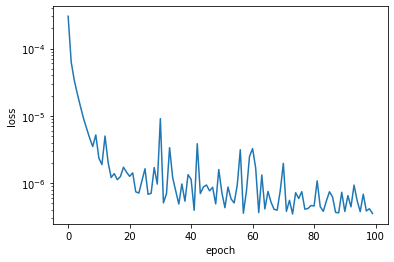

In [19]:
# plot result
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

In [24]:
# LSTM model
#Ustvarimo funkcijo, ki vrača kompajlan LSTM model
def create_model_LSTM(activation='tanh', optimizer='adam', nsteps=10):
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(16, activation=activation, input_shape=(nsteps, 3)))
    model.add(Dense(3))
    #model.add(Dropout(0.2))
    #model.add(Dense(81, activation=activation))
    #model.add(Dropout(0.2))
    #model.add(Dense(81, activation=activation))
    #model.add(Dropout(0.2))
    #model.add(Dense(81, activation=activation))
    #model.add(Dropout(0.2))
    #model.add(Dense(3, activation='sigmoid'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

In [26]:
myLSTM = create_model_LSTM(nsteps=time_steps_predictor)
history_lstm = myLSTM.fit(X, Y, epochs=100, batch_size=1024, validation_split=0.3)

Epoch 1/100
683/683 [==============================] - 8s 11ms/step - loss: 0.0141 - mae: 0.0564 - val_loss: 2.8839e-04 - val_mae: 0.0114
Epoch 2/100
683/683 [==============================] - 7s 11ms/step - loss: 1.0702e-04 - mae: 0.0066 - val_loss: 2.5926e-05 - val_mae: 0.0034
Epoch 3/100
683/683 [==============================] - 7s 11ms/step - loss: 1.3976e-05 - mae: 0.0026 - val_loss: 8.4890e-06 - val_mae: 0.0020
Epoch 4/100
683/683 [==============================] - 7s 11ms/step - loss: 5.9369e-06 - mae: 0.0016 - val_loss: 4.6575e-06 - val_mae: 0.0014
Epoch 5/100
683/683 [==============================] - 7s 11ms/step - loss: 3.5533e-06 - mae: 0.0012 - val_loss: 3.2600e-06 - val_mae: 0.0012
Epoch 6/100
683/683 [==============================] - 7s 11ms/step - loss: 2.6080e-06 - mae: 0.0011 - val_loss: 2.6087e-06 - val_mae: 0.0011
Epoch 7/100
683/683 [==============================] - 7s 11ms/step - loss: 2.1653e-06 - mae: 0.0010 - val_loss: 2.1059e-06 - val_mae: 9.3542e-04
Epoch 

Epoch 56/100
683/683 [==============================] - 8s 12ms/step - loss: 5.1000e-07 - mae: 5.0808e-04 - val_loss: 4.6595e-07 - val_mae: 3.3572e-04
Epoch 57/100
683/683 [==============================] - 8s 12ms/step - loss: 4.9957e-07 - mae: 5.3074e-04 - val_loss: 5.4532e-07 - val_mae: 4.2457e-04
Epoch 58/100
683/683 [==============================] - 8s 12ms/step - loss: 5.0665e-07 - mae: 4.8646e-04 - val_loss: 2.8079e-06 - val_mae: 0.0014
Epoch 59/100
683/683 [==============================] - 8s 12ms/step - loss: 5.0857e-07 - mae: 5.2931e-04 - val_loss: 3.7489e-07 - val_mae: 2.7236e-04
Epoch 60/100
683/683 [==============================] - 8s 12ms/step - loss: 4.8943e-07 - mae: 5.0056e-04 - val_loss: 7.2177e-07 - val_mae: 6.0162e-04
Epoch 61/100
683/683 [==============================] - 8s 12ms/step - loss: 5.1657e-07 - mae: 5.2848e-04 - val_loss: 1.6452e-06 - val_mae: 0.0010
Epoch 62/100
683/683 [==============================] - 8s 12ms/step - loss: 5.0635e-07 - mae: 5.1870e

In [28]:
myLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1280      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


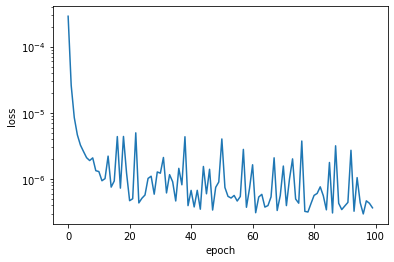

In [29]:
# plot result
plt.plot(history_lstm.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

In [39]:
data

array([[ 5.44583688,  0.42496935, 29.85383253],
       [ 4.96376284,  0.3444128 , 29.08781084],
       [ 4.52206367,  0.30720144, 28.33747874],
       ...,
       [ 7.03574141, 11.5342555 , 16.22611339],
       [ 7.49860581, 12.25563006, 16.65230318],
       [ 0.        ,  0.        ,  0.        ]])

In [31]:
# Primerjava modelov z integratorjem
tmax = 10
n = int(tmax/dt)+1
data_lorenz_RNN = np.zeros((n,3))
data_lorenz_LSTM = np.zeros((n,3))
data_lorenz_IN = np.zeros((n,3))

# define new IC
t=0
i=0

#izberemo zacetni pogoj nekje na atraktorju
y0=data[int(np.random.uniform(1000,data.shape[0]))]

#definiramo parametre Lorenzovega modela
params = [10., 28., 8./3.]

# definiramo ODE solver
solver_ATM = ode(lorenz).set_integrator('dopri5')
solver_ATM.set_f_params(params)
solver_ATM.set_initial_value(y0_ATM, t)
solver_ATM.set_initial_value(y0, t)

data_lorenz_IN[0, :]= y0
data_lorenz_RNN[0, :]= y0
data_lorenz_LSTM[0, :]=y0

i=1
t=dt

print("Calculating...")
start = time()

while i < time_steps_predictor:
    # zacetna stanja kar z generatorjem naredimo, prvih n_steps
    y_ATM = solver_ATM.integrate(t+dt)
    data_lorenz_IN[i, :] = y_ATM[:]
    data_lorenz_RNN[i, :] = y_ATM[:]
    data_lorenz_LSTM[i, :] = y_ATM[:]
    
    i = i + 1
    t += dt
    
while t < tmax:
    # naprej pa gremo z NN
    y_ATM = solver_ATM.integrate(t+dt)
    data_lorenz_IN[i,:] = y_ATM[:]
    
    norm_input_RNN=scaler.transform(data_lorenz_RNN[i-time_steps_predictor:i,:])
    norm_input_LSTM=scaler.transform(data_lorenz_LSTM[i-time_steps_predictor:i,:])
    
    norm_output_rnn=myModel.predict(norm_input_RNN.reshape(1, time_steps_predictor, 3))
    norm_output_lstm=myLSTM.predict(norm_input_LSTM.reshape(1, time_steps_predictor, 3))
    
    data_lorenz_RNN[i,:]=scaler.inverse_transform(norm_output_rnn)
    data_lorenz_LSTM[i,:]=scaler.inverse_transform(norm_output_lstm)
    
    i = i + 1
    t = t+dt
print("Finished in %.3g" %(time()-start))

Calculating...
Finished in 55.8


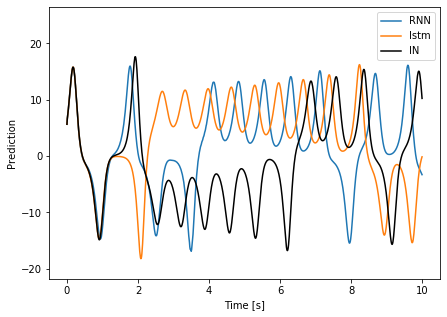

In [33]:
idx=0
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_RNN[:,idx], label='RNN')
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_LSTM[:,idx], label='lstm')
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_IN[:,idx], label='IN', c='k')
plt.legend()
plt.ylabel("Prediction")
plt.xlabel("Time [s]")
plt.ylim(min(data_lorenz_IN[:, idx]) - 5, max(data_lorenz_IN[:, idx]) * 1.5)
plt.show()

Napoved za input velikosti 10:
RNN, LSTM ~ 1,5s 

In [40]:
# Napoved za input velikosti 100
time_steps_predictor = 100
X, Y = split_sequences(normalized_data, time_steps_predictor)

In [ ]:
myRNN_100 = create_model_RNN(n_steps=time_steps_predictor)
history_rnn_100 = myRNN_100.fit(X, Y, epochs=100, batch_size=1024, validation_split=0.3)

myLSTM_100 = create_model_LSTM(nsteps=time_steps_predictor)
history_lstm_100 = myLSTM_100.fit(X, Y, epochs=100, batch_size=1024, validation_split=0.3)